In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, clear_output
import time
import os
import datetime

In [2]:
class Car:

    def __init__(self,car_id,init_s=0.0,init_v=0.0):
        self.id = car_id
        self.s = init_s
        self.init_s = init_s
        # displacement, save itit value for rest
        
        self.v = init_v
        self.init_v = init_v
        # velocity, save itit value for rest
        
        self.a = 0.0 
        # acceleration

        self.s_history = [self.s]
        self.v_history = [self.v]
        self.a_history = [self.a]
        # arreys to save data
    
    def reset(self):
        self.s = self.init_s
        self.v = self.init_v
        self.a = 0.0
     
        self.s_history = [self.s]
        self.v_history = [self.v]
        self.a_history = [0.0]
        # reset to initial values
        
    def set_a(self, a):
        self.a = a
        # get acceleration
        """
        accel is the system input of the auto car project
        the accel of ego car will be defined by NN
        the accels of others car will be generate by some defined rule
        for example, randomly
        """

    def step(self, dt):
        self.s += self.v*dt+0.5*self.a*dt*dt
        self.v += dt*self.a

        self.s_history.append(self.s)
        self.v_history.append(self.v)
        self.a_history.append(self.a)
        """ 
        save all history of displacement (s) and velocity (v) 
        into the arrey self.s_history and self.v_history
        """
        
        

In [7]:
def run_single_simulation(simulation_time,dt):
    np.random.seed()
    #np.random.seed(24)
    
    random_gap = np.random.uniform(20,30)
    random_v = np.random.uniform(10,15)
    
    ego_car = Car(car_id="ego",init_s=0.0,init_v=random_v)
    #generate ego car at initial point with random velocity
    
    front_car = Car(car_id="front",init_s=2*random_gap,init_v=random_v)
    back_car = Car(car_id="back",init_s=-random_gap,init_v=random_v)
    #generate the front car and the back car as well
    
    cars = [ego_car, front_car, back_car]
    
    #print(f"New cars are created!")
    #print(f"The ego car is at {ego_car.s} m, with v={ego_car.v} m/s and a={ego_car.a} m/s^2")
    #print(f"The front car is at {front_car.s} m, with v={front_car.v} m/s and a={front_car.a} m/s^2")
    #print(f"The back car is at {back_car.s} m, with v={back_car.v} m/s and a={back_car.a} m/s^2")
    
    
    #simulation_time = 50.0
    #dt = 0.1
    
    a_set_P = 0.2
    a_set = 0.0
    a_set_random = 0.0
    a_set_max = 1.5
    d_diff = 0.0
    d_diff_accept = 4.0
    
    #a_step_disterbance = 0.1
    
    
    d_2_front = [2*random_gap]
    d_2_back = [random_gap]
    v_2_front = [0.0]
    v_2_back = [0.0]
    
    for car in cars:
        car.reset()
    
    time_steps = np.arange(0.0,simulation_time,dt)
    
    for k in range(len(time_steps)):
        d_diff = d_2_front[-1]-d_2_back[-1]
        
        if np.abs(d_diff) <= d_diff_accept:
            a_set = 0.0
        else:
            a_set = np.sign(d_diff)*a_set_max
            
        ego_car.set_a(a_set)
    
        np.random.seed()
        a_set_random = np.random.uniform(-3.0,3.0)
        front_car.set_a(a_set_random)
        back_car.set_a(a_set_random)
        
        ego_car.step(dt)
        front_car.step(dt)
        back_car.step(dt)
    
        d_2_front.append(front_car.s-ego_car.s)
        d_2_back.append(ego_car.s-back_car.s)
        v_2_front.append(front_car.v-ego_car.v)
        v_2_back.append(ego_car.v-back_car.v)
    
        if d_2_front[-1]<=0 or d_2_back[-1]<=0:
            #print("Here's a car crash!!! ")
            break

    
        
    
    print(f"Simulation finished!")
    
    plot_time_axis = np.arange(len(ego_car.s_history))*dt
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    axes[0].set_title('Car Position', fontsize=16)
    axes[0].set_xlabel('Time (s)', fontsize=12)
    axes[0].set_ylabel('Position (m)', fontsize=12)
    axes[0].plot(plot_time_axis, ego_car.s_history, label='Ego Car', color='red', linewidth=2)
    axes[0].plot(plot_time_axis, front_car.s_history, label='Front Car', color='blue', linestyle='--')
    axes[0].plot(plot_time_axis, back_car.s_history, label='Back Car', color='green', linestyle='-.')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].set_title('Ego Car Accel', fontsize=16)
    axes[1].set_xlabel('Time (s)', fontsize=12)
    axes[1].set_ylabel('Acceleration (m/s^2)', fontsize=12)
    axes[1].plot(plot_time_axis, ego_car.a_history, label='Ego Car Acceleration', color='purple')
    axes[1].legend()
    axes[1].grid(True)
    plt.show() 

    return {
        "d_front": d_2_front,
        "d_back": d_2_back,
        "v_front": v_2_front,
        "v_back": v_2_back,
        "ego_a": ego_car.a_history
    }
 

Start to generate data, running 2 times
Running for 1/2 time...
Simulation finished!


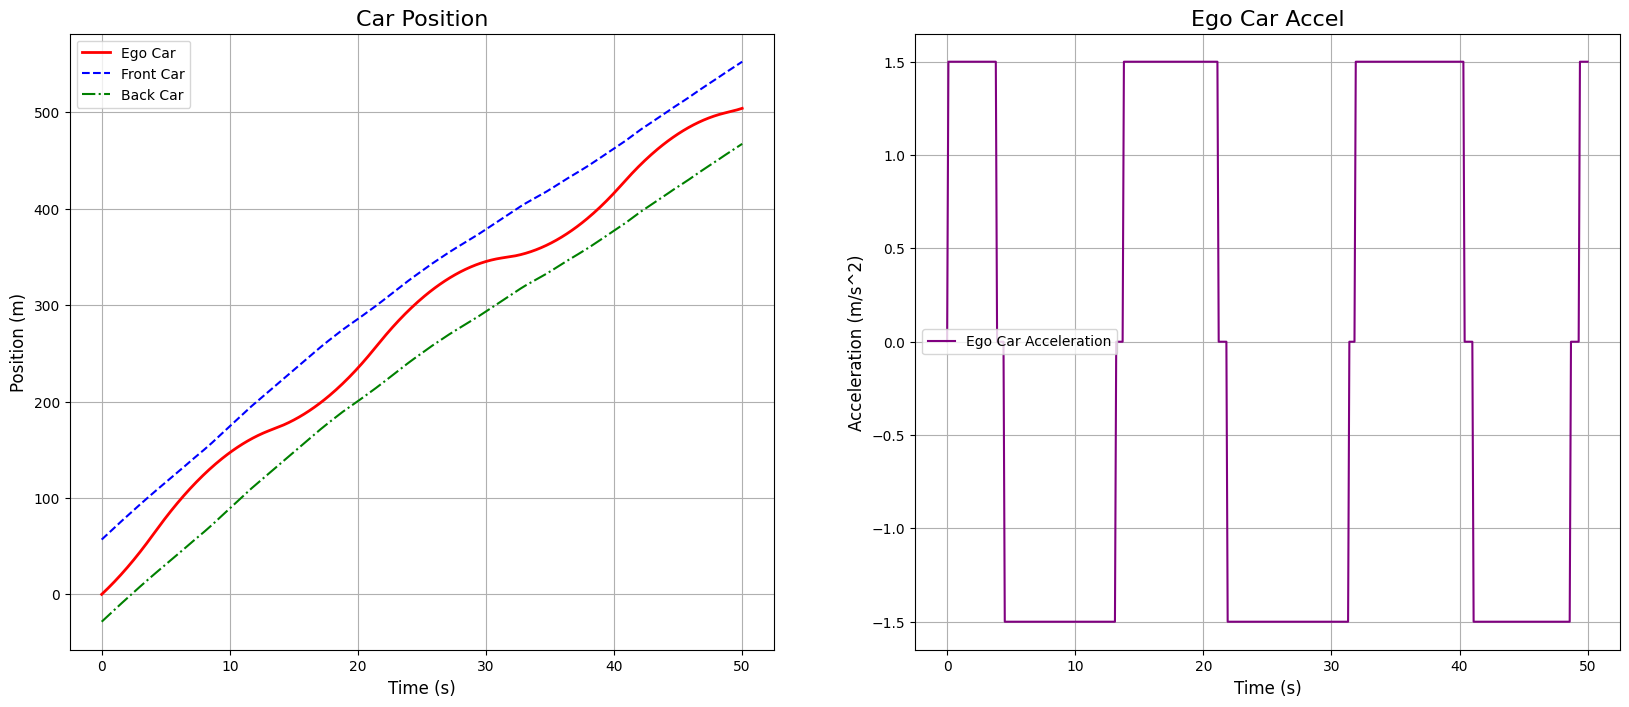

Running for 2/2 time...
Simulation finished!


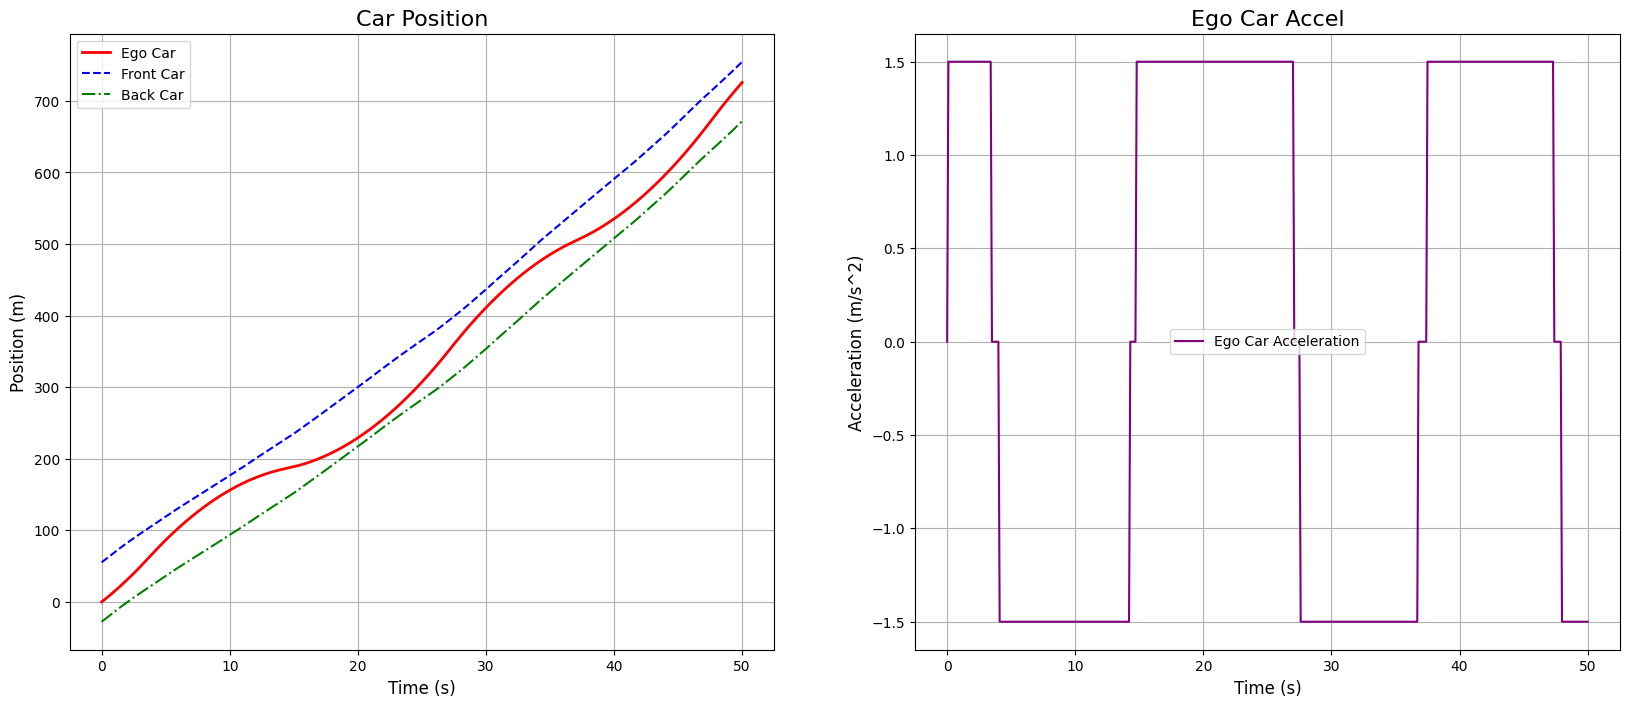

Dataset generated！


In [9]:
num_run = 2
simulation_time = 50
dt = 0.1

all_data = []

print(f"Start to generate data, running {num_run} times")

# --- run simulations ---
for i in range(num_run):
    print(f"Running for {i + 1}/{num_run} time...")
    single_run_data = run_single_simulation(simulation_time, dt)
    all_data.append(single_run_data)

print("Dataset generated！")

In [5]:
processed_data = []
for run_id, run_data in enumerate(all_data):

    num_steps = len(run_data['ego_a'])
    
    for step in range(num_steps):

        record = {
            'run_id': run_id,
            'time_step': step,
            'd_front': run_data['d_front'][step],
            'd_back': run_data['d_back'][step],
            'v_front': run_data['v_front'][step],
            'v_back': run_data['v_back'][step],
            'ego_a': run_data['ego_a'][step]
        }
        processed_data.append(record)

df_to_save = pd.DataFrame(processed_data)
current_dir = os.getcwd()

#print(current_dir)

output_folder = os.path.join(current_dir, 'car-manual-dataset')
os.makedirs(output_folder, exist_ok=True)

timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
file_path = os.path.join(output_folder, f"simulation-dataset-{timestamp_str}.csv")

# try:
#     df_to_save.to_csv(file_path, index=False, encoding='utf-8-sig')
#     print(f"dataset saved at{file_path}")
# except Exception as e:
#     print(f"saving dateset error: {e}")


dataset saved at/Users/ocean/Github/automated-object-control/car-manual-dataset/simulation-dataset-20251010_150818.csv
